# Network Modifications - Transit

In this notebook a copy of our baseline NetworkDataset is made to be modified reflecting the candidate improvement.

New service is modelled by adding a new lines (and connections) to the TransitRoutes layer. Note, "stops" only exist where explicitly defined.


In [ ]:
scenario_name = "ogden_local_bus"
service_type = "local" # choose an appropriate value from the speeds dict below

In [ ]:
operating_speeds = {
    "brt": 30,
    "commuter_rail:": 30,
    "express": 20,
    "core": 16,
    "light_rail": 20,
    "local": 13,
    "street_car": 11
}

import sys
import os
import arcpy
import shutil

base_path = os.path.abspath(".")

src = os.path.join(base_path, 'src')
if src not in sys.path:
    sys.path.append(src)
    
from ato_tools import ato

mode = "Transit"
target_gdb = os.path.join(base_path, "scenario", mode, scenario_name + ".gdb")

In [ ]:
# if target gdb exists, delete it
if os.path.isdir(target_gdb):
    shutil.rmtree(target_gdb)
    
# copy template
shutil.copytree(r"scenario\scenario_template.gdb", target_gdb)

arcpy.env.workspace = target_gdb

# Add Transit layers to map for editing
arcpy.management.MakeFeatureLayer(
    os.path.join(target_gdb, r"NetworkDataset\TransitRoutes"), 
    "TransitRoutes"
)
arcpy.management.MakeFeatureLayer(
    os.path.join(target_gdb, r"NetworkDataset\TransitStops"), 
    "TransitStops"
)
arcpy.management.MakeFeatureLayer(
    os.path.join(target_gdb, r"NetworkDataset\ConnectorNetwork"), 
    "ConnectorNetwork"
)

if service_type not in operating_speeds.keys():
    print("Invalid service type.")
    print("Valid service types:")
    pprint(operating_speeds.keys())

# Make Edits

### Improvements Table

Project Type (new and upgrades)|Action
---- | ----
Bus rapid transit (line)|Add line (new) or change route type & increase speed (upgrade)
Commuter rail (line) - extension|(probably evaluated in regional TDM)
Core route (line)|Add line (new)
Light rail (line)|Add line (new)
Street car (line)|Add line (new)

Ignoring for now: Park & Ride, Infill Station

## New Route

1. Add new feature to TransitRoutes Layer. 
2. Create new stops as required. Make sure that vertex points are coincident between a) the BikePedAuto layer; b) the TransitRoutes layer; and c) the TransitStops layer. This layer connectivity (connected by coincident vertices and TransitStop features) is essential for the correct function of Network Analyst.
3. Ensure that geometry precisely connects to stops or the ConnectorNetwork. Zoom way in. Move or create vertices as necessary.
4. With the new feature selected, run the cell below to set travel times.



## Service Upgrade

1. Select affected feature (ideally by using "Select by Location" and select "within" segments), uncomment the appropriate speed in the cell below, and run

(Alternatively, for service upgrades on new fixed routes, follow the steps above for New Route)

In [ ]:
# UPDATE TransitTime FOR SELECTED FEATURES
# SELECT ONLY AFFECTED FEATURES TO KEEP RUN TIME REASONABLE

expression = '!Length_Miles! * 60 / ' + str(operating_speeds[service_type])

if 0 < int(arcpy.management.GetCount("TransitRoutes")[0]) < 100:
    arcpy.management.CalculateField(
        "TransitRoutes",
        "Length_Miles", '!Shape_Length! * 0.000621371', "PYTHON3", 
        None, "DOUBLE"
    )
    arcpy.management.CalculateField(
        "TransitRoutes", "TransitTime", expression, "PYTHON3", None, "DOUBLE"
    )
else:
    print("Warning: operation will affect " + 
          arcpy.management.GetCount("TransitRoutes")[0] + 
          " features - did you select only the intended target?")

# Save Edits

**Don't forget to save your edits!**

Save edits to transit layers and remove from map. Then run the cells below to create the network dataset and build it.

In [ ]:
# save edits - then build the network

# clear the selection before creating the new network dataset
try:
    arcpy.management.SelectLayerByAttribute("TransitRoutes", "CLEAR_SELECTION")
    arcpy.management.SelectLayerByAttribute("TransitStops", "CLEAR_SELECTION")
    arcpy.management.SelectLayerByAttribute("ConnectorNetwork", "CLEAR_SELECTION")
except:
    pass

nd = os.path.join(target_gdb, r"NetworkDataset\NetworkDataset_ND")

# Build the dataset
ato.build(nd)

In [ ]:
ato.test(nd, mode = 'Transit')

# Transit Modeling Assumptions

New service is modelled by adding a new lines (and connections) to the TransitRoutes layer. Note, "stops" only exist where explicitly defined.

### Assumed Operating Speeds

Route Type | Operating Speed
---- | ----
BRT|30 mph
Commuter Rail|30 mph
Light rail|20 mph
Express bus|20 mph
Core route|16 mph
Local route|13 mph
Street car|11 mph

Average speeds of commuter rail routes are 29 mph.

Average speeds of current bus routes:

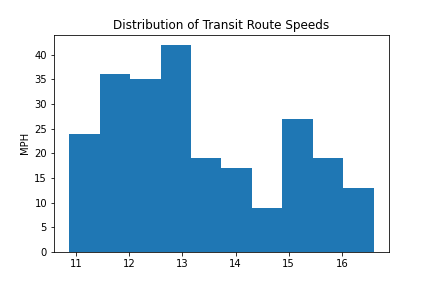
